In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os

In [ ]:
!pwd

/content


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/face_mask_detection

/content/drive/MyDrive/Colab Notebooks/face_mask_detection


In [ ]:
INIT_LR = 1e-4
EPOCHS = 50
BS = 32

In [ ]:
print("[INFO] loading images...")
imageTrainPaths = list(paths.list_images('New Masks Dataset/Train'))
imageTestPaths = list(paths.list_images('New Masks Dataset/Test'))
imageValidPaths = list(paths.list_images('New Masks Dataset/Validation'))

[INFO] loading images...


In [9]:
def splitImageLabel(imagePaths):
  random.shuffle(imagePaths)
  data = []
  labels = []

  for imagePath in imagePaths:
    #print(imagePath.split(os.path.sep)[-2])
    label = imagePath.split(os.path.sep)[-2]

    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

  return data, labels

In [10]:
trainData, trainLabels = splitImageLabel(imageTrainPaths)
validData, validLabels = splitImageLabel(imageValidPaths)
testData, testLabels = splitImageLabel(imageTestPaths)

In [11]:
print(f'Length of trainData:{len(trainData)}')
print(f'Length of validData:{len(trainData)}')
print(f'Length of testData:{len(trainData)}')

Length of trainData:600
Length of validData:600
Length of testData:600


In [12]:
def labelBinarize(data, Labels, lb):
  data = np.array(data, dtype='float32')
  Labels = np.array(Labels)
  #lb = LabelBinarizer()
  Labels = lb.fit_transform(Labels)
  Labels = to_categorical(Labels)
  return data, Labels

In [13]:
lb = LabelBinarizer()

trainData, trainLabels = labelBinarize(trainData, trainLabels, lb)
validData, validLabels = labelBinarize(validData, validLabels, lb)
testData, testLabels = labelBinarize(testData, testLabels, lb)

In [14]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
baseModel = MobileNetV2(weights='imagenet', include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [16]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

In [17]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [18]:
#model.summary()

In [19]:
for layer in baseModel.layers:
  layer.trainable = False

In [20]:
print("[INFO] compiling...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling...


In [21]:
history = model.fit(aug.flow(trainData, trainLabels, batch_size=BS),
                    #steps_per_epoch=len(trainData)//BS,
                    validation_data=(validData, validLabels),
                    #validation_steps=len(validData)//BS,
                    epochs=EPOCHS)

Epoch 1/50
19/19 [==============================] - 39s 358ms/step - loss: 0.7214 - accuracy: 0.5650 - val_loss: 0.4713 - val_accuracy: 0.8922
Epoch 2/50
19/19 [==============================] - 6s 321ms/step - loss: 0.4417 - accuracy: 0.8533 - val_loss: 0.3066 - val_accuracy: 0.9510
Epoch 3/50
19/19 [==============================] - 6s 310ms/step - loss: 0.2996 - accuracy: 0.9233 - val_loss: 0.2214 - val_accuracy: 0.9641
Epoch 4/50
19/19 [==============================] - 6s 311ms/step - loss: 0.2378 - accuracy: 0.9400 - val_loss: 0.1714 - val_accuracy: 0.9641
Epoch 5/50
19/19 [==============================] - 6s 309ms/step - loss: 0.1722 - accuracy: 0.9617 - val_loss: 0.1403 - val_accuracy: 0.9739
Epoch 6/50
19/19 [==============================] - 6s 312ms/step - loss: 0.1573 - accuracy: 0.9733 - val_loss: 0.1195 - val_accuracy: 0.9739
Epoch 7/50
19/19 [==============================] - 6s 313ms/step - loss: 0.1246 - accuracy: 0.9817 - val_loss: 0.1048 - val_accuracy: 0.9804
Epoch

In [22]:
print('[INFO] evaluating network...')
predIdxs = model.predict(testData, batch_size=BS)

[INFO] evaluating network...


In [23]:
predIdxs = np.argmax(predIdxs, axis=1)

In [24]:
print(classification_report(testLabels.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

        Mask       1.00      1.00      1.00        50
    Non Mask       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [25]:
print("[INFO] saving face mask detector model...")
model.save('face_mask_detector.model', save_format='h5')

[INFO] saving face mask detector model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


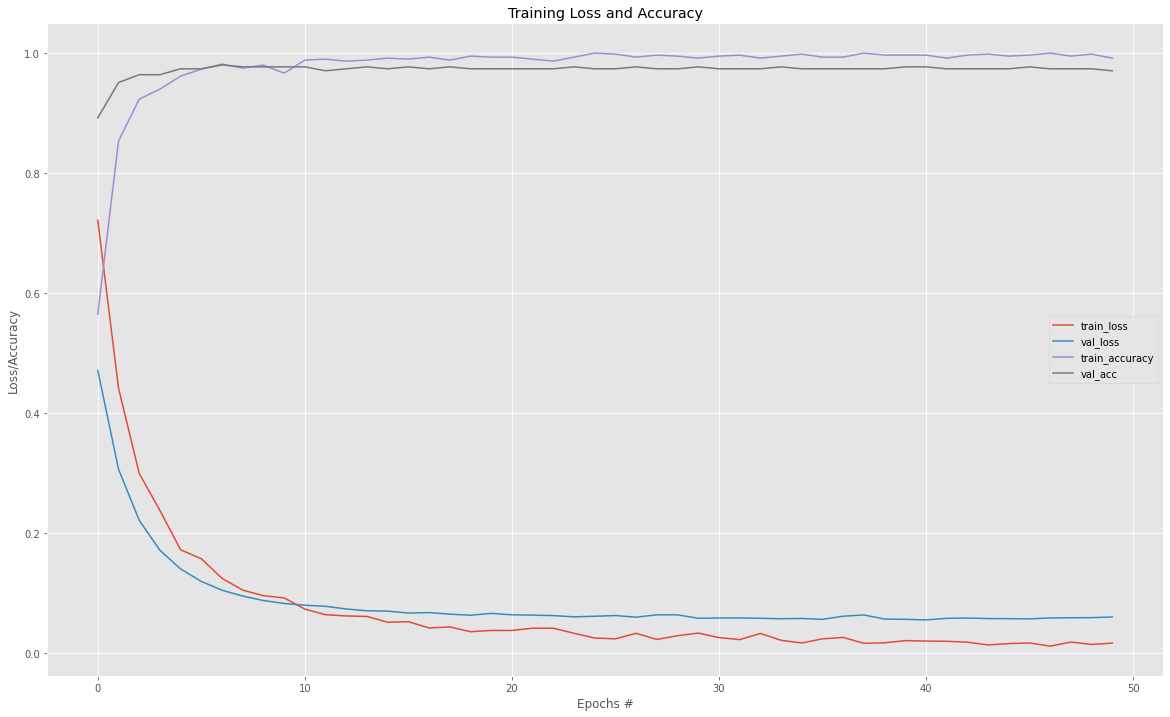

In [30]:
N = EPOCHS
H = history

plt.style.use('ggplot')
plt.figure(figsize=(20, 12))
plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label='train_accuracy')
plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='center right')
plt.savefig('plot.png')
plt.show()